In [1]:
### Make notebook wider:

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
# reloads imports (utils) if something changes
%load_ext autoreload
%autoreload 2

In [3]:
# replace and redo previoulsy processed data = True, else = False
Replace = True

In [25]:
#Set paths 


# Animal_ID =['EJT363','EJT164','EJT165','EJT167','EJT169']
Animal_ID = ['BG1','BG2','BG3','BG4']
#'SP77','SP78','SP79',
#['EJT153','EJT154','EJT155','EJT156','EJT157','EJT159','EJT160','EJT161']
#['SP28','EJT97','T98','EJT99','EJT100','EJT101','EJT102','EJT103','EJT104','EJT105','EJT106','EJT107','EJT108','EJT109','EJT110','EJT111','EJT112','EJT113','EJT114','EJT115','EJT116','EJT117','EJT118','EJT119']
             
             #'EJT68','EJT69','EJT70','EJT71','EJT72','EJT73','EJT74','EJT75','EJT76','EJT77','EJT78','EJT79','EJT80','EJT81','EJT82','EJT83','EJT84','EJT85','EJT87','EJT88','EJT89','EJT90','EJT94','EJT95','EJT96','SP19','SP20','SP21','SP22','SP27','SP28','SP29','SP30']
             #,'EJT64','EJT65','EJT66','EJT67','EJT68','EJT69','EJT70','EJT71','EJT72','EJT73','EJT74','EJT75','EJT76','EJT77','EJT78','EJT79','EJT80','EJT81','EJT82','EJT83','EJT84','EJT86','EJT87','EJT89']

#'EJT83','EJT84','EJT85',


# ['EJT60','EJT61','EJT62','EJT63','EJT64','EJT65','EJT66','EJT67','EJT68','EJT69','EJT70','EJT71','EJT72','EJT73','EJT74','EJT75','EJT76','EJT77','EJT78','EJT79','EJT80','EJT81','EJT82','EJT83','EJT84','EJT86','EJT87','EJT89'],

InputPath = ('Z:\data\\bpod_raw_data\\')
CameraPath = ('Z:\data\\EJT_FlyCap_SeqTracking\\')

OutputPath = ('D:\Behavioural_data_output\\')


In [26]:
## import functions from .py utils file: 
from Utilities.preprocessing import *

# MAIN:

In [27]:
#### MAIN ####
for Animal_index, CurrentAnimal in enumerate(Animal_ID):
    print ('Processing data for: ' + CurrentAnimal)
    InputPathCurrent = (InputPath + CurrentAnimal + '\Sequence_Automated\Session Data\\')
    
    #Load Behavioural data:
    Behav_data, Sessions,Path,FileDates = Import_Bpod_DataFiles(InputPathCurrent)
    
    Processed = ('')
    Skipped = ('')
 

    for Session in range(0,Sessions):

        
        filedate = FileDates[Session] + '_' + str(Behav_data[Session]['__header__'])[-25:-22]

        if Session < 10:
            Save_path = (OutputPath + CurrentAnimal + '\Preprocessed' + '\\0' + str(Session) + '_' + filedate)
        else:
            Save_path = (OutputPath + CurrentAnimal + '\Preprocessed' + '\\' + str(Session) + '_' + filedate)

        # see if dir exists already then use bool logic to detemrine if it needs to be processed or not
        if not os.path.isdir(Save_path):
            os.makedirs(Save_path)
            Process = True
        else:
            if  Replace == True:
                Process = True
            else:
                Process = False

        if  Process == True:

            #Convert to python friendly format:
            convert_nested_structs(Behav_data[Session])

        #         # Extract GUI info
            Trial_settings = todict(Behav_data[Session]['SessionData']['TrialSettings'][0])
            FinalRewardAmount = []
            for item in Behav_data[Session]['SessionData']['SessionVariables']['TLevel']:
                TLevel = item
                FinalRewardAmount = FinalRewardAmount + [Behav_data[Session]['SessionData']['SessionVariables']['TrainingLevels'][TLevel-1][4]]

            # save out training levels on their own
            filename = 'Preprocessed_TrainingLevels' 
            with open(Save_path + '\\'+ filename, 'wb') as fp:
                pickle.dump(Behav_data[Session]['SessionData']['SessionVariables']['TLevel'], fp)

            # save out led intensites and reward amounts on their own:
            LED_Intensities = pd.DataFrame({'Port2':Behav_data[Session]['SessionData']['SessionVariables']['LEDIntensitys']['port2'],
                                   'Port3':Behav_data[Session]['SessionData']['SessionVariables']['LEDIntensitys']['port3'],
                                   'Port4':Behav_data[Session]['SessionData']['SessionVariables']['LEDIntensitys']['port4'],
                                   'Port5':Behav_data[Session]['SessionData']['SessionVariables']['LEDIntensitys']['port5']})
            LED_Intensities.to_csv(Save_path + '/Preprocessed_LED_Intensities.csv')
            RewardAmounts = pd.DataFrame({'Port1':Behav_data[Session]['SessionData']['SessionVariables']['RewardAmount']['port1'],
                                           'Port2':Behav_data[Session]['SessionData']['SessionVariables']['RewardAmount']['port2'],
                                           'Port3':Behav_data[Session]['SessionData']['SessionVariables']['RewardAmount']['port3'],
                                           'Port4':Behav_data[Session]['SessionData']['SessionVariables']['RewardAmount']['port4']})
            RewardAmounts.to_csv(Save_path + '/Preprocessed_RewardAmounts.csv')


            #Extract PortIn times for each port and check for errors (inside this function):
            All_PortIn_Times,All_PortOut_Times,All_Port_references = extract_poke_times(Behav_data[Session])

            
            #remove nans (times when part [in or out poke] of the event was dropped for some reason by bpod)
            All_PortIn_Times_fixed,All_PortOut_Times_fixed ,All_Port_references_fixed = remove_dropped_in_events(All_PortIn_Times,All_PortOut_Times,All_Port_references)
            
            # Resort these in time:
            All_PortIn_Times_sorted,All_PortOut_Times_sorted,All_Port_references_sorted = time_sort(All_PortIn_Times,All_PortOut_Times,All_Port_references)
            
            #fix stupid error that suddently appeared
            if len(All_Port_references_sorted) == 1:
                All_Port_references_sorted = All_Port_references_sorted[0]
                All_PortIn_Times_sorted = All_PortIn_Times_sorted[0]
                All_PortOut_Times_sorted = All_PortOut_Times_sorted[0]
            #extract reward times:
            Reward_ts = extract_reward_times(Behav_data[Session])

            # find reward inds and align rewarded ts to poke events:
            Rewarded_event_inds = find_reward_inds(All_PortIn_Times_sorted,All_Port_references_sorted,Reward_ts)
            Reward_ts = np.asarray(Reward_ts)
            Reward_ts = Reward_ts[np.logical_not(np.isnan(Reward_ts))]
            Reward_ts = list(Reward_ts)
            Reward_ts_aligned = align_trigger_to_index(Reward_ts,Rewarded_event_inds,All_Port_references_sorted)

            #extract trial start time stamps
            Trial_start_ts = extract_trial_timestamps(Behav_data[Session])

            #extract trial end times:
            Trial_end_ts = extract_trial_end_times(Behav_data[Session])

            #determine trial IDs
            trial_id = determine_trial_id(All_PortIn_Times_sorted,Trial_end_ts)

            # align trial start and end times to poke events
            trialstart_index = find_trialstart_index(trial_id)
            trial_start_ts_aligned = align_trial_start_end_timestamps(trial_id,trialstart_index,Trial_start_ts)
            trial_end_ts_aligned = align_trial_start_end_timestamps(trial_id,trialstart_index,Trial_end_ts)

            # optostim data:
            if Trial_settings['GUI']['OptoStim'] == 1: 
                ## save out opto settings as a dataframe
                Opto_StimPoke = Trial_settings['GUI']['StimPoke']
                Opto_PulsePower = Trial_settings['GUI']['PulsePower']
                Opto_OptoChance = Trial_settings['GUI']['OptoChance']
                Opto_PulseDuration = Trial_settings['GUI']['PulseDuration']
                Opto_PulseInterval = Trial_settings['GUI']['PulseInterval']
                Opto_TrainDuration = Trial_settings['GUI']['TrainDuration']
                #create opto dataframe
                Opto_settings = pd.DataFrame(
                {'StimPoke' : [Opto_StimPoke],
                 'PulsePower':[Opto_PulsePower],
                 'OptoChance':[Opto_OptoChance],
                 'PulseDuration' : [Opto_PulseDuration],
                 'PulseInterval':[Opto_PulseInterval],
                 'TrainDuration':[Opto_TrainDuration]})
                #save
                Opto_settings.to_csv(Save_path + '/Opto_settings.csv')

                #pull out optotrials from data
                optotrials = Behav_data[Session]['SessionData']['SessionVariables']['OptoStim']
                #align these to dataframe:
                executed_optotrials = optotrials[0:trial_id[-1]]
                optotrials_aligned = align_opto_trials_to_dataframe(trial_id,executed_optotrials)
            else:
                #no optostim so fill this column with NaNs
                optotrials_aligned = ['NaN'] * len(trial_id)

            #determine LED and reward states for each trial and align them to trials:
            IntermediateRewards = []
            LED_intensities = []
            for item in Behav_data[Session]['SessionData']['SessionVariables']['TLevel']:
                TLevel = item
                IntermediateRewards = IntermediateRewards + [list(Behav_data[Session]['SessionData']['SessionVariables']['TrainingLevels'][TLevel-1][0:4])]
                LED_intensities = LED_intensities + [list(Behav_data[Session]['SessionData']['SessionVariables']['TrainingLevels'][TLevel-1][6:10])]
            aligned_LED_intensities = align_trial_start_end_timestamps(trial_id,trialstart_index,LED_intensities)
            aligned_IntermediateRewards = align_trial_start_end_timestamps(trial_id,trialstart_index,IntermediateRewards)

            #Search for timestamps for given animal and session 
            TimeStampsExist, TimeStampPath = FindTimestamps(filedate,CameraPath,CurrentAnimal)
            

            if TimeStampsExist:
                print('Timestamps Found')
                #Load camera timestamps:
                Camera_ts_raw = load_camera_timestamps(TimeStampPath)
                #Convert to seconds and uncycle:
                Camera_ts = convert_uncycle_Timestamps(Camera_ts_raw)
                #check for dropped frames:
                check_timestamps(Camera_ts, Frame_rate = 40)
                # Find triggers:
                Camera_trig_states = find_trigger_states(Camera_ts_raw)
                #check if triggers are working:
                result = np.max(Camera_trig_states) == np.min(Camera_trig_states)
                if not result:
                    # make camera dataframe:
                    Camera_dataframe = pd.DataFrame(
                        {'Time Stamps': Camera_ts,
                        'Trigger State': Camera_trig_states,
                        'DataPath': ([TimeStampPath] * len(Camera_ts))})

                    #Save Data
                    Camera_dataframe.to_csv(Save_path + '/PreProcessed_CameraData.csv')

                    #find camera inds that align with trigger start and stop events (trial start and first poke):
                    Trial_start_camera_inds,Poke1_camera_inds = Find_TrialStart_and_Poke1_camera_inds(Camera_trig_states)
                    #align behavioural data (trial starts) with camera timestamps 
                    Trial_start_Camera_Ts_aligned = align_trial_start_end_timestamps(trial_id,trialstart_index,Camera_ts[Trial_start_camera_inds])
                    
                    

                    #align behavioural data (trial ends) with camera timestamps 
                    Trial_end_Camera_Ts_aligned = generate_aligned_trial_end_camera_ts(Trial_start_camera_inds,trial_id,trialstart_index,Camera_ts)
                    #align behavioural data (first poke in port1) with camera timestamps 
                    First_poke_Camera_Ts_aligned = align_firstpoke_camera_timestamps(trial_id,trialstart_index,Camera_ts[Poke1_camera_inds],All_Port_references_sorted)
                

                
                else:
                    print('Triggers Broken')
                    TimeStampsExist = False
                    Trial_start_Camera_Ts_aligned = ['NaN'] * len(trial_id)
                    Trial_end_Camera_Ts_aligned = ['NaN'] * len(trial_id)
                    First_poke_Camera_Ts_aligned = ['NaN'] * len(trial_id)
            else:
                Trial_start_Camera_Ts_aligned = ['NaN'] * len(trial_id)
                Trial_end_Camera_Ts_aligned = ['NaN'] * len(trial_id)
                First_poke_Camera_Ts_aligned = ['NaN'] * len(trial_id)

            ## align Training level for each trial:
            Training_Levels = align_opto_trials_to_dataframe(trial_id,Behav_data[Session]['SessionData']['SessionVariables']['TLevel'])

            # make portin dataframe:
            PortIn_df = pd.DataFrame(
                {'Trial_id' : trial_id,
                 'Trial_Start' : trial_start_ts_aligned,
                 'Port': All_Port_references_sorted,
                 'PokeIn_Time': All_PortIn_Times_sorted,
                 'PokeOut_Time': All_PortOut_Times_sorted,
                 'Reward_Times': Reward_ts_aligned,
                 'Trial_End' : trial_end_ts_aligned,
                 'Trial_Start_Camera_Time':Trial_start_Camera_Ts_aligned,
                 'Trial_End_Camera_Time':Trial_end_Camera_Ts_aligned,
                 'First_poke_camera_timestamp': First_poke_Camera_Ts_aligned,
                 'Port 2,3,4,5 LED intensities': aligned_LED_intensities,
                 'Port 1,2,3,4 RewardAmount':aligned_IntermediateRewards,
                 'OptoCondition':optotrials_aligned,
                'TrainingLevel': Training_Levels})
            
            #Save Data
            PortIn_df.to_csv(Save_path +'/PreProcessed_RawPokeData.csv')

            #PART2##########################Transitions:

            #Determine Transition times and types for all events 
            ##old way:
#             Transition_times, Transition_types,transition_reference_time = Determine_Transition_Times_and_Types(All_PortIn_Times_sorted , All_Port_references_sorted)
            out_in_Transition_times, in_in_Transition_times, Transition_types, out_in_transition_reference,in_in_transition_reference = Determine_Transition_Times_and_Types(All_PortIn_Times_sorted ,All_PortOut_Times_sorted, All_Port_references_sorted)
            
            
            #Split transtion types into first and last ports: 
            start_port_ids = Start_End_port_id(Transition_types,0)
            end_port_ids = Start_End_port_id(Transition_types,1)
            #Align start and end port times
            End_Port_in_time = All_PortIn_Times_sorted[1::]
            Start_Port_in_time = All_PortIn_Times_sorted[0:-1]
            End_Port_out_time = All_PortOut_Times_sorted[1::]
            Start_Port_out_time = All_PortOut_Times_sorted[0:-1]
            #Find Port repeat events (double pokes)
            Non_Port_repeat = determine_RepeatPort_events(start_port_ids,end_port_ids)
            #Determine which transitions are good: less than 1.5s
            out_in_Filtered_transitions = filter_transitons_by_latency(out_in_Transition_times, 2)
            in_in_Filtered_transitions = filter_transitons_by_latency(in_in_Transition_times, 2)

            if TimeStampsExist:
                # Align camera ts to each transition event 
                ## calculate from each time stamp
                first_port_camera_ts = port_events_in_camera_time(trial_start_ts_aligned,Start_Port_in_time,Trial_start_Camera_Ts_aligned)
                second_port_camera_ts = first_port_camera_ts + in_in_Transition_times
            else:
                first_port_camera_ts = ['NaN'] * len(Transition_types)
                second_port_camera_ts = ['NaN'] * len(Transition_types)

            # make dataframe:
            Transition_df = pd.DataFrame(
                {'Trial_id' : trial_id[0:-1],
                'Transition_type' : Transition_types,
                 'Start_Port':start_port_ids, 
                 'End_Port':end_port_ids,
                 'Start_Poke_in_time': Start_Port_in_time,
                 'Start_Poke_out_time': Start_Port_out_time,
                 'End_Poke_in_time': End_Port_in_time,
                 'End_Poke_out_time': End_Port_out_time,
                 'out_in_Latency' : out_in_Transition_times,
                 'in_in_Latency': in_in_Transition_times,
                 'First_port_in_camera_time':first_port_camera_ts,
                 'Second_port_in_camera_time':second_port_camera_ts,
                 'Repeat_Filter':Non_Port_repeat,
                 '2s_Time_Filter_out_in': out_in_Filtered_transitions,
                 '2s_Time_Filter_in_in': in_in_Filtered_transitions,
                 'OptoCondition':optotrials_aligned[0:-1],
                 'TrainingLevel': Training_Levels[0:-1],
                 'Port 2,3,4,5 LED intensities': aligned_LED_intensities[0:-1],
                 'Port 1,2,3,4 RewardAmount':aligned_IntermediateRewards[0:-1]})
            #Save Data
            Transition_df.to_csv(Save_path + '/PreProcessed_TransitionData.csv')

            #PART3#########################Sequences:

            # Define useful port/seq related information
            port1 = Behav_data[Session]['SessionData']['TrialSequence'][0][0]
            port2 = Behav_data[Session]['SessionData']['TrialSequence'][0][1]
            port3 = Behav_data[Session]['SessionData']['TrialSequence'][0][2]
            port4 = Behav_data[Session]['SessionData']['TrialSequence'][0][3]
            port5 = Behav_data[Session]['SessionData']['TrialSequence'][0][4]
            sequence1 = int(str(port1) + str(port2))
            sequence2 = int(str(port2) + str(port3))
            sequence3 = int(str(port3) + str(port4))
            sequence4 = int(str(port4) + str(port5))

            #Filter transitons into sequences for each port by finding port and then transitions that happen after that port which are in a string that satisfies the transition filter time
            # there is now a lower filter - ie. any sequences that are shorter than 0.05 are discounted:
            ## these are from in to in as we dont care about transiton times, just poke in times for eahc port 
            Port1_Time_Filtered_seq_ids,Port1_Time_Filtered_seq_times,Port1_Reference_times = CreateSequences_TimeandPort(Transition_types,in_in_Transition_times,port1,in_in_transition_reference,Transition_filter_time = 2.0)
            Port2_Time_Filtered_seq_ids,Port2_Time_Filtered_seq_times,Port2_Reference_times = CreateSequences_TimeandPort(Transition_types,in_in_Transition_times,port2,in_in_transition_reference,Transition_filter_time = 2.0)
            Port3_Time_Filtered_seq_ids,Port3_Time_Filtered_seq_times,Port3_Reference_times = CreateSequences_TimeandPort(Transition_types,in_in_Transition_times,port3,in_in_transition_reference,Transition_filter_time = 2.0)
            Port4_Time_Filtered_seq_ids,Port4_Time_Filtered_seq_times,Port4_Reference_times = CreateSequences_TimeandPort(Transition_types,in_in_Transition_times,port4,in_in_transition_reference,Transition_filter_time = 2.0)
            Port5_Time_Filtered_seq_ids,Port5_Time_Filtered_seq_times,Port5_Reference_times = CreateSequences_TimeandPort(Transition_types,in_in_Transition_times,port5,in_in_transition_reference,Transition_filter_time = 2.0)

            #Filter transitons into sequences that are within the transition filter time (not filtered to start at first poke):
            Time_Filtered_seq_ids,Time_Filtered_seq_times,Reference_times = CreateSequences_Time(Transition_types,out_in_Transition_times,port1,in_in_transition_reference,Transition_filter_time = 2.0)

            # make dataframes:
            Sequence_df_timefiltered_port1aligned = pd.DataFrame(
                {'Sequence_ids' : Port1_Time_Filtered_seq_ids,
                 'Sequence_times':Port1_Time_Filtered_seq_times,
                 'SessionTime_Reference':Port1_Reference_times})
            Sequence_df_timefiltered_port2aligned = pd.DataFrame({
                 'Sequence_ids' : Port2_Time_Filtered_seq_ids,
                 'Sequence_times':Port2_Time_Filtered_seq_times,
                 'SessionTime_Reference':Port2_Reference_times})
            Sequence_df_timefiltered_port3aligned = pd.DataFrame({    
                 'Sequence_ids' : Port3_Time_Filtered_seq_ids,
                 'Sequence_times':Port3_Time_Filtered_seq_times,
                 'SessionTime_Reference':Port3_Reference_times})
            Sequence_df_timefiltered_port4aligned = pd.DataFrame({     
                 'Sequence_ids' : Port4_Time_Filtered_seq_ids,
                 'Sequence_times':Port4_Time_Filtered_seq_times,
                 'SessionTime_Reference':Port4_Reference_times})
            Sequence_df_timefiltered_port5aligned = pd.DataFrame({
                 'Sequence_ids' : Port5_Time_Filtered_seq_ids,
                 'Sequence_times':Port5_Time_Filtered_seq_times,
                 'SessionTime_Reference':Port5_Reference_times})

            Sequence_timefilteredonly_df = pd.DataFrame(
                {'Sequence_ids' : Time_Filtered_seq_ids,
                 'Sequence_times':Time_Filtered_seq_times,
                 'SessionTime_Reference':Reference_times})

            #Save Data
            Sequence_df_timefiltered_port1aligned.to_csv(Save_path + '/PreProcessed_Sequence_df_timefiltered_port1aligned.csv')
            Sequence_df_timefiltered_port2aligned.to_csv(Save_path + '/PreProcessed_Sequence_df_timefiltered_port2aligned.csv')
            Sequence_df_timefiltered_port3aligned.to_csv(Save_path + '/PreProcessed_Sequence_df_timefiltered_port3aligned.csv')
            Sequence_df_timefiltered_port4aligned.to_csv(Save_path + '/PreProcessed_Sequence_df_timefiltered_port4aligned.csv')
            Sequence_df_timefiltered_port5aligned.to_csv(Save_path + '/PreProcessed_Sequence_df_timefiltered_port5aligned.csv')

            Sequence_timefilteredonly_df.to_csv(Save_path + '/PreProcessed_Sequence_timefilteredonly_df.csv')

            #Make final session information dataframe
            TrainingLevels = list(Trial_settings['GUIMeta']['TrainingLevel']['String'])
            SessionLevel = Trial_settings['GUI']['TrainingLevel']
            no_rewarded_events = number_of_rewarded_events(Reward_ts_aligned)
            
            #experiment or training session:
            if Trial_settings['GUI']['ExperimentType'] == 2:
                Experiment = 1
            else:
                Experiment = 0

            Session_information = pd.DataFrame(
                {'Port1' : [port1],
                 'Port2':[port2],
                 'Port3':[port3],
                 'Port4':[port4],
                 'Port5':[port5],
                'Transition1':sequence1,
                'Transition2':sequence2,
                'Transition3':sequence3,
                'Transition4':sequence4,
                'n_Trials': trial_id[-1],
                'n_rewards': no_rewarded_events,
                'FinalRewardAmount': [FinalRewardAmount],
                'SessionLevel':[TLevel],
                'Experiment':Experiment,
                'CameraData': TimeStampsExist,})

            #Save Data
            Session_information.to_csv(Save_path + '/PreProcessed_SessionInfo.csv')
            Processed = (Processed + str(Session) +',')
        else:
            Skipped = (Skipped + str(Session) +',')
    
    print('Already Processed so skipped: ' + Skipped)
    print('Processed: ' + Processed)

print('finished')

Processing data for: BG1
BG1_Sequence_Automated_20240205_141338.mat
BG1_Sequence_Automated_20240206_143639.mat
BG1_Sequence_Automated_20240207_162517.mat
BG1_Sequence_Automated_20240208_152042.mat
BG1_Sequence_Automated_20240209_141315.mat
BG1_Sequence_Automated_20240212_141903.mat
BG1_Sequence_Automated_20240213_152427.mat
BG1_Sequence_Automated_20240214_150400.mat
BG1_Sequence_Automated_20240215_171550.mat
BG1_Sequence_Automated_20240216_172018.mat
BG1_Sequence_Automated_20240219_170156.mat
BG1_Sequence_Automated_20240220_150307.mat
BG1_Sequence_Automated_20240221_165227.mat
BG1_Sequence_Automated_20240223_154019.mat
BG1_Sequence_Automated_20240226_142525.mat
BG1_Sequence_Automated_20240227_194449.mat
BG1_Sequence_Automated_20240229_154755.mat
Already Processed so skipped: 
Processed: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,
Processing data for: BG2
BG2_Sequence_Automated_20240205_135132.mat
BG2_Sequence_Automated_20240206_144049.mat
BG2_Sequence_Automated_20240207_152550.mat
BG2_Se

In [28]:
len(All_PortOut_Times_sorted)

627

In [20]:
All_PortOut_Times_sorted

array([ 100.7841, 1000.131 , 1001.6247, ...,  998.7049,  999.4051,
             nan])

In [192]:
result

False

In [158]:
PortIn_df = pd.DataFrame(
    {'Trial_id' : trial_id,
     'Trial_Start' : trial_start_ts_aligned,
     'Port': All_Port_references_sorted,
     'PokeIn_Time': All_PortIn_Times_sorted,
     'PokeOut_Time': All_PortOut_Times_sorted,
     'Reward_Times': Reward_ts_aligned,
     'Trial_End' : trial_end_ts_aligned,
     'Trial_Start_Camera_Time':Trial_start_Camera_Ts_aligned,
     'Trial_End_Camera_Time':Trial_end_Camera_Ts_aligned,
     'First_poke_camera_timestamp': First_poke_Camera_Ts_aligned,
     'Port 2,3,4,5 LED intensities': aligned_LED_intensities,
     'Port 1,2,3,4 RewardAmount':aligned_IntermediateRewards,
     'OptoCondition':optotrials_aligned,
    'TrainingLevel': Training_Levels})

                        


In [40]:
Trial_end_Camera_Ts_aligned = generate_aligned_trial_end_camera_ts(Trial_start_camera_inds,trial_id,trialstart_index,Camera_ts)

In [46]:
Trial_start_camera_inds

[1223,
 2672,
 2916,
 4033,
 4276,
 4489,
 4633,
 4883,
 5081,
 5367,
 5861,
 6529,
 7036,
 7225,
 7566,
 7859,
 8043,
 8576,
 8718,
 10110,
 10437,
 11174,
 11449,
 11594,
 11719,
 12367,
 12695,
 12829,
 12964,
 13116,
 13304,
 13542,
 13727,
 13869,
 14022,
 14198,
 14339,
 14584,
 14699,
 14843,
 15124,
 15750,
 15879,
 16012,
 16129,
 16559,
 16699,
 16823,
 17013,
 17505,
 17684,
 18433,
 18993,
 19244,
 19442,
 19754,
 19932,
 20070,
 20247,
 20381,
 20550,
 20812,
 20968,
 21140,
 21279,
 21518,
 21743,
 21894,
 22078,
 22327,
 22513,
 22678,
 22785,
 22934,
 23126,
 23252,
 23559,
 23720,
 23870,
 24060,
 24189,
 24325,
 24499,
 24622,
 24791,
 25165,
 25296,
 25444,
 25557,
 25694,
 25820,
 25946,
 26166,
 26273,
 26425,
 26558,
 26828,
 26968,
 27436,
 27571,
 27694,
 27952,
 28083,
 28213,
 28340,
 28495,
 28634,
 28794,
 28957,
 29267,
 29539,
 29654,
 29788,
 29919,
 30078,
 30198,
 30953,
 31103,
 31220,
 31362,
 31484,
 31653,
 31803,
 31931,
 32179,
 32289,
 32435,
 32

In [141]:
def generate_aligned_trial_end_camera_ts(Trial_start_camera_inds,trial_id,trialstart_index,Camera_ts):
    end_inds = []
    for index,item in enumerate(Trial_start_camera_inds):
        if index > 0:
            end_inds = end_inds + [item]

    Trial_end_Camera_Ts_aligned = align_trial_start_end_timestamps(trial_id,trialstart_index,Camera_ts[end_inds])
    last_trial_length = (len(trial_id) - trialstart_index[-1])
    if len(Trial_end_Camera_Ts_aligned) == len(trial_id): # this was a bit of a hacky fix, not rally sure about this - it all needs rewriting
        del Trial_end_Camera_Ts_aligned[(last_trial_length * -1)::] 
    Trial_end_Camera_Ts_aligned = Trial_end_Camera_Ts_aligned + (['NaN'] * last_trial_length )
    return Trial_end_Camera_Ts_aligned 

In [143]:
len(Trial_end_Camera_Ts_aligned)

1898

In [137]:
last_trial_length

6

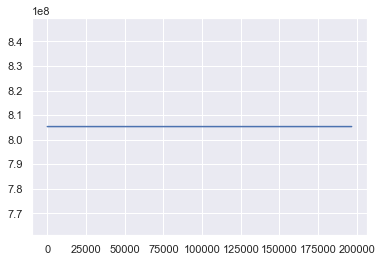

In [173]:
plt.plot(list(Camera_ts_raw['Trigger']))

In [145]:
Trial_start_Camera_Ts_aligned[-50::]

[4783.636125,
 4788.8095,
 4788.8095,
 4788.8095,
 4788.8095,
 4788.8095,
 4788.8095,
 4788.8095,
 4788.8095,
 4788.8095,
 4788.8095,
 4792.2585,
 4792.2585,
 4792.2585,
 4792.2585,
 4792.2585,
 4792.2585,
 4796.171625,
 4796.171625,
 4796.171625,
 4796.171625,
 4796.171625,
 4796.171625,
 4796.171625,
 4796.171625,
 4800.0185,
 4800.0185,
 4804.926625,
 4804.926625,
 4804.926625,
 4804.926625,
 4804.926625,
 4804.926625,
 4804.926625,
 4804.926625,
 4804.926625,
 4804.926625,
 4804.926625,
 4804.926625,
 4804.926625,
 4804.926625,
 4808.5745,
 4808.5745,
 4808.5745,
 4814.8755,
 4814.8755,
 4814.8755,
 4814.8755,
 4814.8755,
 4814.8755]

In [81]:
def align_trial_start_end_timestamps(trial_id,trialstart_index,Trial_start_ts):
    trial_ts_aligned = []
    counter = 0
    for i in range(len(trial_id)):
        if counter+1 < len(trialstart_index):
            if i == trialstart_index[counter+1]:
                counter = counter + 1
        if counter < len(Trial_start_ts):
            trial_ts_aligned = trial_ts_aligned + [Trial_start_ts[counter]]
    return trial_ts_aligned

6946

In [55]:
trialstart_index[-1]

6946

In [59]:
len(Trial_end_Camera_Ts_aligned)

6946

In [166]:
date

'16/04/21'

In [167]:
file_date

'140421'

In [170]:


def FindTimestamps(filedate,CameraPath,CurrentAnimal):
#     Search for timestamps for given animal and session

    file_date = filedate[6:8] + filedate[4:6] + filedate[2:4]

    TimeStampsExist = False
    TimeStampPath = 'N/A'

    if os.path.isdir(CameraPath + CurrentAnimal):
        Dirs = sorted(os.listdir(CameraPath + CurrentAnimal))
        if file_date in Dirs:
            sub_dir = (os.listdir(CameraPath + CurrentAnimal+'\\'+ file_date))
            for file in sub_dir:
                if file[-2] == 's': #if its a .csv and not a avi
                    if file != '.DS_Store': #if file is not the weird hidden file 

                        date,time = determine_datetime(os.path.join(CameraPath,CurrentAnimal,file_date,file))

                        if not time == file_date:
                            raise NameError('Camera timestamp data is not from same date as behaviour data')

                        if int(time) < int(filetime):   
                            TimeStampsExist = True
                            TimeStampPath = CameraPath + CurrentAnimal + '\\' + file_date + '\\' + file
                            break
                        else:
                            print('camera started after behvaiour so ts ignored')
                        
    return TimeStampsExist, TimeStampPath



In [115]:
# def FindTimestamps(Path,Session,CameraPath,CurrentAnimal):
    #Search for timestamps for given animal and session
    #find current data date
datafiles= []
for item in Path:
    if item[-3::] == 'mat':
        datafiles = datafiles + [item]

current_file = datafiles[Session]
file_date = current_file[-15:-3]
file_date = current_file[-13:-11] + current_file[-15:-13] + current_file[-17:-15] 
filetime = current_file[-10:-4]

TimeStampsExist = False
TimeStampPath = 'N/A'

if os.path.isdir(CameraPath + CurrentAnimal):
    Dirs = sorted(os.listdir(CameraPath + CurrentAnimal))
    if file_date in Dirs:
        sub_dir = (os.listdir(CameraPath + CurrentAnimal+'\\'+ file_date))
        for file in sub_dir:
            if file[-2] == 's': #if its a .csv and not a avi
                if file != '.DS_Store': #if file is not the weird hidden file 
                    camerafiletime = file[-12:-4].replace("_", "")
                    if int(camerafiletime) < int(filetime):   
                        TimeStampsExist = True
                        TimeStampPath = CameraPath + CurrentAnimal + '\\' + file_date + '\\' + file
                        break
                    else:
                        print('camera started after behvaiour so ts ignored')



ValueError: invalid literal for int() with base 10: 'stamps'

In [116]:
file_date

'140421'

In [107]:
filetime

'115247'

In [135]:
currentfile_date, currentfile_time = determine_datetime(os.path.join(InputPathCurrent,current_file))

In [136]:
currentfile_date

'16/04/21'

In [133]:
 

determine_datetime(os.path.join(CameraPath,CurrentAnimal,file_date,file))

SyntaxError: unmatched ')' (<ipython-input-133-ec512fb71ae6>, line 1)

In [132]:
def determine_datetime(pathtofile):

    import datetime
    ctime = datetime.datetime.fromtimestamp(os.path.getctime(pathtofile))
    time = ctime.strftime('%H%M%S')
    date = ctime.strftime('%d/%m/%y') 
    
    return date,time

In [127]:
ctime.strftime('%d/%m/%y') 

'16/04/21'

In [123]:
ctime

datetime.datetime(2021, 4, 16, 14, 38, 3, 689053)

In [80]:
a = os.path.join(CameraPath,CurrentAnimal,file_date,file)

In [100]:
os.stat(os.path.join(CameraPath,CurrentAnimal,file_date,file)).st_ctime

1618580283.689053

In [74]:
Path

['EJT84_Sequence_Automated_20210301_125533.fig',
 'EJT84_Sequence_Automated_20210301_125533.mat',
 'EJT84_Sequence_Automated_20210302_110353.fig',
 'EJT84_Sequence_Automated_20210302_110353.mat',
 'EJT84_Sequence_Automated_20210303_112518.fig',
 'EJT84_Sequence_Automated_20210303_112518.mat',
 'EJT84_Sequence_Automated_20210305_143352.fig',
 'EJT84_Sequence_Automated_20210305_143352.mat',
 'EJT84_Sequence_Automated_20210308_125248.fig',
 'EJT84_Sequence_Automated_20210308_125248.mat',
 'EJT84_Sequence_Automated_20210309_105323.fig',
 'EJT84_Sequence_Automated_20210309_105323.mat',
 'EJT84_Sequence_Automated_20210310_104719.fig',
 'EJT84_Sequence_Automated_20210310_104719.mat',
 'EJT84_Sequence_Automated_20210311_104554.fig',
 'EJT84_Sequence_Automated_20210311_104554.mat',
 'EJT84_Sequence_Automated_20210312_103031.fig',
 'EJT84_Sequence_Automated_20210312_103031.mat',
 'EJT84_Sequence_Automated_20210315_115411.fig',
 'EJT84_Sequence_Automated_20210315_115411.mat',
 'EJT84_Sequence_Aut

In [42]:
Session

26

In [43]:
CameraPath

'Z:\\data\\EJT_FlyCap_SeqTracking\\'

In [14]:
def align_firstpoke_camera_timestamps(trial_id,trialstart_index,Trial_start_ts,All_Port_references_sorted):
    counter = 0
    trial_ts_aligned = []
    for index,item in enumerate(trial_id):
        if All_Port_references_sorted[index] == 2.0:
            if item > counter:
                counter = counter + 1
                trial_ts_aligned = trial_ts_aligned + [Trial_start_ts[counter-1]]
            else:
                trial_ts_aligned = trial_ts_aligned + ['NaN']
        else:
            trial_ts_aligned = trial_ts_aligned + ['NaN']
    return trial_ts_aligned

523

In [40]:
Session

26

In [24]:
Trial_start_ts = Camera_ts[Poke1_camera_inds]

counter = 0
trial_ts_aligned = []
for index,item in enumerate(trial_id):
    if All_Port_references_sorted[index] == 2.0:
        if item > counter:
            counter = counter + 1
            trial_ts_aligned = trial_ts_aligned + [Trial_start_ts[counter-1]]
        else:
            trial_ts_aligned = trial_ts_aligned + ['NaN']
    else:
        trial_ts_aligned = trial_ts_aligned + ['NaN']

IndexError: index 522 is out of bounds for axis 0 with size 522

In [39]:
len(Camera_ts[Poke1_camera_inds])

522

In [36]:
determine_trial_id(All_PortIn_Times_sorted,Trial_end_ts)[-1]

1312

In [33]:
trial_id[-10::]

[1311, 1311, 1311, 1312, 1312, 1312, 1312, 1312, 1312, 1312]

In [37]:
trialstart_index

[0,
 11,
 22,
 29,
 48,
 55,
 73,
 80,
 85,
 91,
 96,
 101,
 107,
 114,
 120,
 126,
 131,
 138,
 144,
 150,
 167,
 173,
 178,
 185,
 225,
 233,
 239,
 247,
 253,
 259,
 265,
 270,
 276,
 284,
 293,
 304,
 310,
 317,
 325,
 331,
 339,
 344,
 349,
 355,
 363,
 374,
 383,
 390,
 396,
 401,
 406,
 412,
 419,
 428,
 433,
 440,
 445,
 452,
 459,
 464,
 471,
 478,
 484,
 493,
 498,
 504,
 510,
 533,
 541,
 548,
 554,
 560,
 566,
 571,
 577,
 583,
 591,
 599,
 606,
 613,
 619,
 627,
 633,
 642,
 649,
 655,
 662,
 668,
 674,
 681,
 688,
 695,
 703,
 709,
 718,
 723,
 734,
 741,
 747,
 754,
 762,
 770,
 778,
 784,
 792,
 797,
 802,
 808,
 819,
 824,
 829,
 837,
 845,
 851,
 857,
 862,
 867,
 875,
 883,
 894,
 901,
 906,
 912,
 919,
 925,
 931,
 939,
 944,
 950,
 957,
 963,
 968,
 976,
 981,
 991,
 997,
 1003,
 1008,
 1016,
 1021,
 1028,
 1033,
 1040,
 1046,
 1053,
 1065,
 1073,
 1079,
 1085,
 1090,
 1101,
 1106,
 1115,
 1120,
 1127,
 1133,
 1142,
 1150,
 1157,
 1162,
 1182,
 1189,
 1201,
 1206,
